# Explore Risk Factors for COVID-19 for San Diego County
[Work in progress]

This notebook explores the relationsship between risk factors selected from the American Community Survey 2018 5-year estimates on COVID-19 confirmed case and death rate.

In [1]:
import math
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.dates import DateFormatter
from py2neo import Graph
import ipywidgets as widgets

In [2]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

#### Connect to COVID-19-Net Knowledge Graph

In [3]:
graph = Graph("bolt://132.249.238.185:7687", user="reader", password="demo")

### Query KG to get Confirmed Cases, Deaths, and Population for Zip Code areas in San Diego County

In [4]:
metric = 'confirmedRate'

In [5]:
# start date for time series
start_date = '2020-04-01'

#### Get confirmed cases and deaths

In [6]:
query = """
// get all zip codes in San Diego County
MATCH (p:PostalCode)-[:IN]-(a:Admin2{name: 'San Diego County'})

// get COVID-19 cases for all counties
//MATCH (c:Cases{date: source: 'SDHHSA'})-[:REPORTED_IN]->(p:PostalCode)
//RETURN p.name as zip, p.placeName, p.location, c.cummulativeConfirmed as confirmed, c.date as date
//ORDER by zip

MATCH (p)<-[:REPORTED_IN]-(c:Cases{source: 'SDHHSA'}) 
WHERE c.date >= date($start_date)

// get demographics for all counties
MATCH (p)-[:HAS_DEMOGRAPHICS]->(d:Demographics) 

RETURN p.name + '-' + p.placeName AS name, c.date AS date, 
       c.cummulativeConfirmed*100000.0/d.totalPopulation AS confirmedRate, 
       c.cummulativeDeaths*100000.0/d.totalPopulation AS deathRate
ORDER BY c.date ASC, a.name
"""
df = graph.run(query, start_date=start_date).to_data_frame()

Reformat data

In [7]:
# convert neo4j date object to datetime
df['date'] = df['date'].astype(str)
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=False)  
# pivot table
df_date = df.pivot(index='date', columns='name', values=metric)
df_date.fillna(0, inplace=True)
df_date.head()

name,91901-Alpine,91902-Bonita,91905-Boulevard,91906-Campo,91910-Chula Vista,91911-Chula Vista,91913-Chula Vista,91914-Chula Vista,91915-Chula Vista,91916-Descanso,91917-Dulzura,91932-Imperial Beach,91934-Jacumba,91935-Jamul,91941-La Mesa,91942-La Mesa,91945-Lemon Grove,91950-National City,91962-Pine Valley,91963-Potrero,91977-Spring Valley,91978-Spring Valley,91980-Tecate,92003-Bonsall,92004-Borrego Springs,92007-Cardiff By The Sea,92008-Carlsbad,92009-Carlsbad,92010-Carlsbad,92011-Carlsbad,92014-Del Mar,92019-El Cajon,92020-El Cajon,92021-El Cajon,92024-Encinitas,92025-Escondido,92026-Escondido,92027-Escondido,92028-Fallbrook,92029-Escondido,92036-Julian,92037-La Jolla,92040-Lakeside,92054-Oceanside,92055-Camp Pendleton,92056-Oceanside,92057-Oceanside,92058-Oceanside,92059-Pala,92060-Palomar Mountain,92061-Pauma Valley,92064-Poway,92065-Ramona,92066-Ranchita,92067-Rancho Santa Fe,92069-San Marcos,92070-Santa Ysabel,92071-Santee,92075-Solana Beach,92078-San Marcos,92081-Vista,92082-Valley Center,92083-Vista,92084-Vista,92086-Warner Springs,92091-Rancho Santa Fe,92101-San Diego,92102-San Diego,92103-San Diego,92104-San Diego,92105-San Diego,92106-San Diego,92107-San Diego,92108-San Diego,92109-San Diego,92110-San Diego,92111-San Diego,92113-San Diego,92114-San Diego,92115-San Diego,92116-San Diego,92117-San Diego,92118-Coronado,92119-San Diego,92120-San Diego,92121-San Diego,92122-San Diego,92123-San Diego,92124-San Diego,92126-San Diego,92127-San Diego,92128-San Diego,92129-San Diego,92130-San Diego,92131-San Diego,92134-San Diego,92135-San Diego,92139-San Diego,92140-San Diego,92145-San Diego,92154-San Diego,92173-San Ysidro,92536-Aguanga
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-01,5.388512,44.691628,0.0,0.0,30.956835,24.600246,37.684655,12.227181,22.054190,50.9684,0.0,7.490356,0.0,12.001920,12.351779,29.847034,36.774170,27.139641,0.0,0.0,33.126686,19.015022,0.0,0.0,41.425021,35.606195,25.612880,34.913915,55.793193,20.506931,79.347904,49.528302,57.880222,39.259124,44.663663,20.456743,12.018990,12.321557,10.125557,46.999843,0.0,73.003726,17.293184,16.598297,0.0,18.571827,11.997189,10.894670,0.0,0.0,84.175084,26.034887,16.524829,349.65035,137.048881,9.718740,0.0,20.865574,31.685678,18.354611,30.607040,5.535566,2.561279,17.503258,0.0,74.460164,73.766947,31.460674,183.496760,68.581036,37.063475,36.687631,9.631437,66.474629,45.438586,50.148775,28.357876,46.743254,29.983295,28.852140,97.728552,32.043864,17.790429,16.673614,48.040629,64.446831,24.773938,54.459252,31.084862,25.432350,36.945054,48.956253,32.735605,37.963699,14.552228,0.0,0.0,45.896328,0.0,83.717036,28.798194,25.105128,0.0
2020-04-02,5.388512,49.657364,0.0,0.0,37.686582,28.114567,39.568888,18.340772,25.204789,50.9684,0.0,11.235534,0.0,12.001920,24.703557,29.847034,47.806421,28.736091,0.0,0.0,37.859070,28.522533,0.0,0.0,41.425021,35.606195,29.271862,34.913915,55.793193,24.608318,86.561350,61.320755,66.392019,39.259124,44.663663,22.316447,14.022155,10.561335,12.150668,46.999843,0.0,78.038465,19.454832,18.969483,0.0,20.429009,11.997189,10.894670,0.0,0.0,84.175084,26.034887,19.278967,349.65035,137.048881,13.606236,0.0,24.343169,31.685678,22.433414,34.007822,16.606698,5.122557,19.448064,0.0,148.920328,73.766947,31.460674,186.363897,75.217911,39.808917,47.169811,9.631437,62.042987,49.569366,50.148775,30.383439,52.136706,34.266623,31.889208,91.805609,33.824079,17.790429,25.010421,54.903576,64.446831,26.838433,51.255766,34.193348,26.643414,38.997558,48.956253,32.735605,37.963699,17.462674,0.0,0.0,48.596112,0.0,41.858518,32.253977,37.657692,0.0
2020-04-03,5.388512,49.657364,0.0,0.0,37.686582,30.457447,43.337353,24.454362,37.807183,50.9684,0.0,22.471068,0.0,12.001920,24.703557,29.847034,44.129004,30.332540,0.0,0.0,39.436531,28.522533,0.0,0.0,41.425021,35.606195,29.271862,37.096035,55.793193,28.709704,93.774796,63.679245,71.499098,42.063347,48.547460,22.316447,16.025320,12.321557,12.150668,46.999843,0.0,8

### Get Risk Factors for Counties

* Low income (< $15,000)
* No health insurance
* Service occupation
* Low education level (no high school diploma)
* No broadband internet access
* High occupancy housing (> 1 occupant per room)

In [8]:
query = """
// get all zip codes in San Diego County
MATCH (p:PostalCode)-[:IN]-(a:Admin2{name: 'San Diego County'})

// get population characteristics (American Community Survey 2018 5-year estimates)
MATCH (p)-[:HAS_DEMOGRAPHICS]-(d:Demographics)
MATCH (p)-[:HAS_ECONOMICS]-(:Economics)-[:HAS_INCOME]-(i:Income)
MATCH (p)-[:HAS_ECONOMICS]-(:Economics)-[:HAS_HEALTH_INSURANCE]-(hi:HealthInsurance)
MATCH (p)-[:HAS_ECONOMICS]-(:Economics)-[:HAS_OCCUPATION]-(o:Occupation)
MATCH (p)-[:HAS_SOCIAL_CHARACTERISTICS]-(s:SocialCharacteristics)-[:HAS_EDUCATION]-(e:Education)
MATCH (p)-[:HAS_SOCIAL_CHARACTERISTICS]-(s:SocialCharacteristics)-[:HAS_COMPUTERS]-(c:Computers)
MATCH (p)-[:HAS_HOUSING]-(h:Housing)

// exclude missing values
WHERE d.totalPopulation > 0 AND i.householdIncomeLessThan10000USDPct > 0 AND 
      i.householdIncome10000To14999USDPct > 0 AND h.averageHouseholdSizeOfOwnerOccupiedUnit > 0 AND
      h.ownerOccupiedHousingUnitsPct > 0 AND h.renterOccupiedHousingUnitsPct > 0 AND
      h.averageHouseholdSizeOfOwnerOccupiedUnit > 0 AND h.averageHouseholdSizeOfRenterOccupiedUnit > 0
      
// return risk factors
RETURN p.name +'-' + p.placeName AS name, 
       d.hispanicOrLatino*100/d.totalPopulation AS hispanicOrLatinoPct,
       (d.blackOrAfricanAmerican  + d.americanIndianAndAlaskaNative + d.nativeHawaiianAndOtherPacificIslander)*100.0/d.totalPopulation AS minorityPct,
       (i.householdIncomeLessThan10000USDPct + i.householdIncome10000To14999USDPct) AS lowIncomePct,
       hi.noHealthInsuranceCoveragePct AS noHealthInsurancePct,
       o.serviceOccupationsPct AS serviceOccupationPct,
       e.lessThan9thGradePct + e.grade9thTo12thNoDiplomaPct AS lowEducationPct,
       (100.0 - c.withBroadbandInternetPct) AS noInternetPct,
       (h.`occupantsPerRoom1.01to1.50Pct` + h.`occupantsPerRoom1.51orMorePct`) AS highOccupanyHousingPct,
       h.averageHouseholdSizeOfOwnerOccupiedUnit,
       h.averageHouseholdSizeOfRenterOccupiedUnit,
       (h.averageHouseholdSizeOfOwnerOccupiedUnit*h.ownerOccupiedHousingUnitsPct/100.0) +
       (h.averageHouseholdSizeOfRenterOccupiedUnit*h.renterOccupiedHousingUnitsPct/100.0) AS averageHouseholdSize
ORDER BY a.name
"""
risk_factors = graph.run(query).to_data_frame()
risk_factors.head(100)

,name,hispanicOrLatinoPct,minorityPct,lowIncomePct,noHealthInsurancePct,serviceOccupationPct,lowEducationPct,noInternetPct,highOccupanyHousingPct,h.averageHouseholdSizeOfOwnerOccupiedUnit,h.averageHouseholdSizeOfRenterOccupiedUnit,averageHouseholdSize
0,92065-Ramona,25,1.470710,4.6,8.6,17.0,9.7,9.8,4.7,2.95,3.22,3.01507
1,92102-San Diego,61,10.137079,10.6,18.3,32.6,28.6,19.9,15.4,3.25,2.90,2.99835
2,91905-Boulevard,12,11.366712,24.6,3.7,15.6,8.7,46.5,0.9,2.62,2.06,2.40272
3,92036-Julian,11,5.718145,9.4,4.1,26.5,11.4,35.7,0.2,1.96,1.76,1.90960
4,92026-Escondido,35,3.611706,7.1,11.0,21.6,14.3,13.6,7.0,2.89,2.98,2.92690
5,92124-San Diego,16,6.847995,5.5,3.5,14.4,3.1,4.3,2.4,2.58,3.26,2.93836
6,91942-La Mesa,24,6.058948,10.2,8.0,16.2,8.3,11.2,4.4,2.47,2.39,2.42096
7,92173-San Ysidro,95,0.756292,16.3,14.8,26.5,43.0,25.2,26.1,4.18,3.89,3.97671
8,91977-Spring Valley,45,13.291688,8.5,10.6,23.0,15.2,12.2,7.0,3.28,3.34,3.30496
9,91978-Spring Valley,31,10.971668,7.2,8.8,23.8,10.1,9.2,3.8,3.09,3.27,3.15300


Summary statistics for risk factors

In [9]:
risk_factors.describe()

,hispanicOrLatinoPct,minorityPct,lowIncomePct,noHealthInsurancePct,serviceOccupationPct,lowEducationPct,noInternetPct,highOccupanyHousingPct,h.averageHouseholdSizeOfOwnerOccupiedUnit,h.averageHouseholdSizeOfRenterOccupiedUnit,averageHouseholdSize
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,28.677419,6.438851,8.368817,8.136559,18.867742,11.503226,12.161290,6.089247,2.839677,2.895699,2.855650
std,18.137855,6.873431,4.175445,4.569839,6.537769,8.979935,8.073481,5.349552,0.526222,0.595330,0.518583
min,5.000000,0.000000,2.800000,2.100000,1.300000,0.500000,1.700000,0.200000,1.710000,1.440000,1.505340
25%,14.000000,2.531392,5.900000,4.700000,14.200000,4.800000,7.100000,2.400000,2.480000,2.490000,2.507200
50%,24.000000,4.579566,7.300000,6.800000,18.500000,8.700000,10.500000,4.200000,2.800000,2.900000,2.889680
75%,41.000000,7.820194,9.400000,10.400000,23.500000,15.300000,15.000000,8.200000,3.110000,3.260000,3.144260
max,95.000000,45.604396,24.600000,28.200000,39.300000,43.000000,46.500000,26.100000,4.230000,5.010000,4.212060


##### Create color maps for risk factors (range: mean +/- 2 sigma, colors: blue-white-red)

In [10]:
def get_color_map(factor):
    sigma = 2
    risk_factors[factor+'_z'] = (risk_factors[factor] - risk_factors[factor].mean())/risk_factors[factor].std()/sigma
    risk_factors[factor+'_z'] = risk_factors[factor+'_z'].clip(-1, 1)
    risk_factors[factor+'_z'] = (risk_factors[factor+'_z'] + 1) * 50
    colors = cm.bwr(np.linspace(0, 1, 101))
    risk_factors[factor+'col'] = risk_factors[factor+'_z'].apply(lambda z: colors[int(round(z))])
    return risk_factors[factor+'col'].values

In [11]:
col_latinoOrHispanic = get_color_map('hispanicOrLatinoPct')
col_minority = get_color_map('minorityPct')
col_income = get_color_map('lowIncomePct')
col_insurance = get_color_map('noHealthInsurancePct')
col_service = get_color_map('serviceOccupationPct')
col_education = get_color_map('lowEducationPct')
col_nointernet = get_color_map('noInternetPct')
col_occupancy = get_color_map('highOccupanyHousingPct')
col_household_size = get_color_map('averageHouseholdSize')

### Case rate for all counties color-coded by risk factor

##### Set color map for risk factor

In [12]:
#col_map = col_latinoOrHispanic
#col_map = col_minority
#col_map = col_income
#col_map = col_insurance
#col_map = col_service
#col_map = col_education
col_map = col_nointernet
#col_map = col_occupancy
#col_map = col_household_size

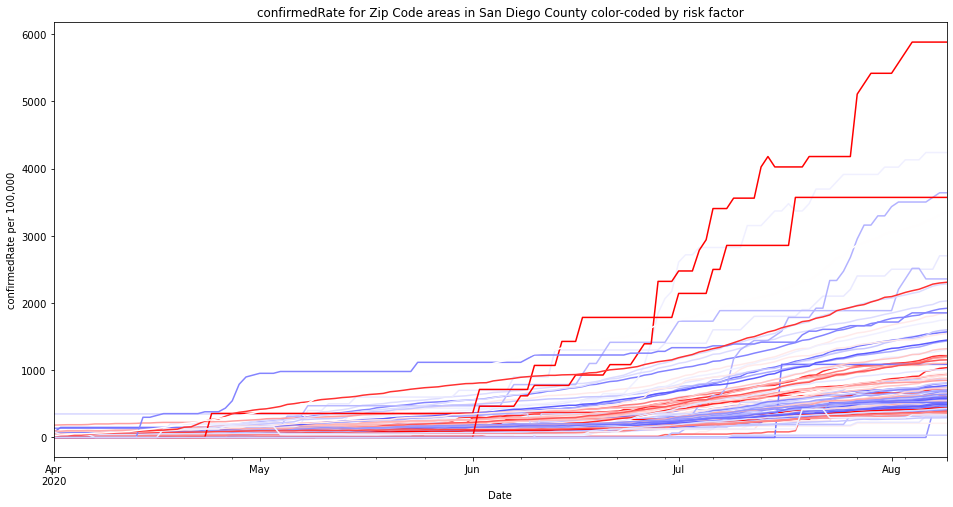

In [13]:
ax = df_date.plot(figsize=(16, 8), color=col_map, legend=False, title=f'{metric} for Zip Code areas in San Diego County color-coded by risk factor');
ax.set_xlabel('Date');
ax.set_ylabel(f'{metric} per 100,000');

### Case counts by county color-coded by risk factor

In [14]:
# dimensions for subplot layout
cols = 5
rows = math.ceil(df_date.shape[1]/cols)

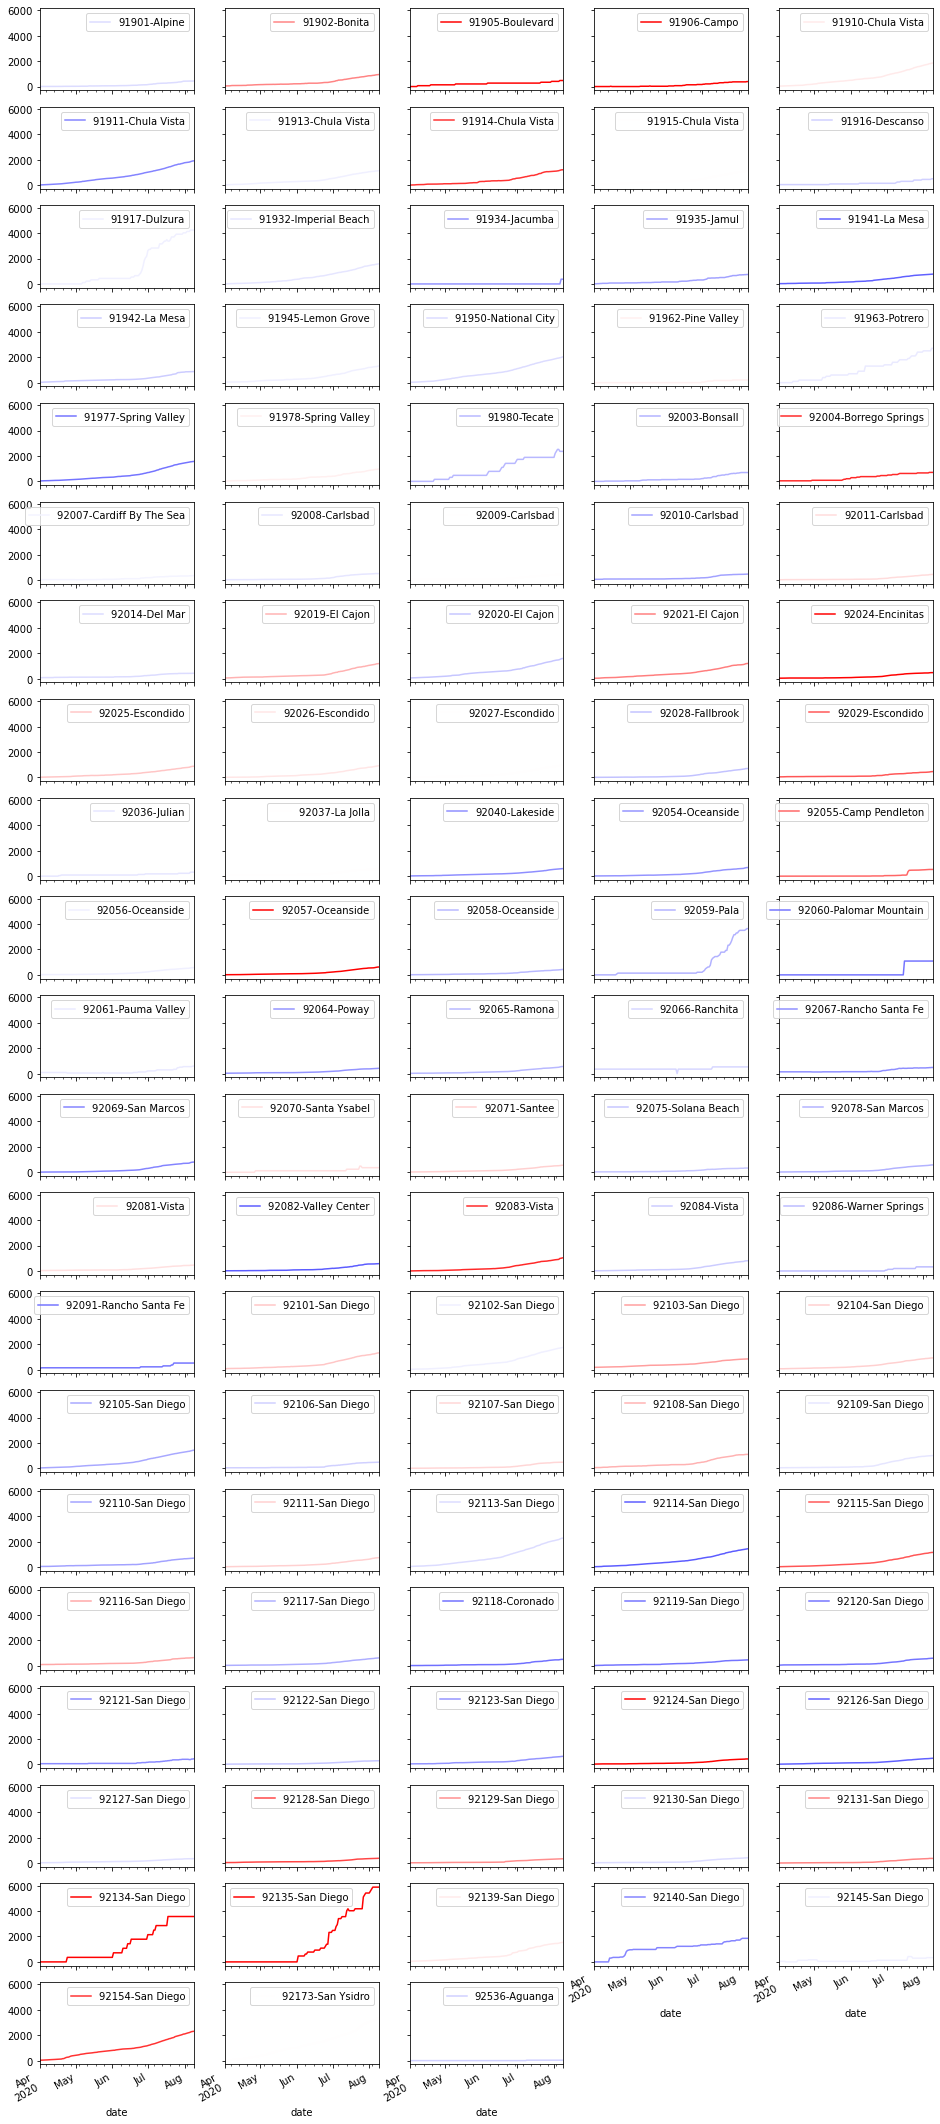

In [15]:
ax = df_date.plot(subplots=True, layout=(rows,cols), sharey=True, figsize=(16, 2*rows), color=col_map);